In [14]:
#google colab installs:
#!pip install dgl
#!DGLBACKEND=pytorch
#!export $DGLBACKEND
#!pip install forgi
#!tar -xf data.tar.xz

import dgl
import numpy as np
import torch as th
import matplotlib.pyplot as plt

#Import Data Modules
from dgl_classifier.data import CGDataset

print(th.__version__)
print(th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using:", device)

#Training Set
import dgl.dataloading as dtl

training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"./data/train_rmsd_list.txt"

training_dataset = CGDataset(training_dir, rmsd_list, device)

#Validation Set
val_dir = "./data/val_set"
val_rmsd = "./data/val_rmsd_list.txt"

val_dataset = CGDataset(val_dir, val_rmsd, device)

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"

test_dataset = CGDataset(test_dir, test_rmsd, device)

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"

st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, device)

1.10.2
True
Using: cuda


TODO:
*  include checkpoints, that save model parameters for later testing **DONE**
*  implement gpu usage **DONE**
*  **ADD NAMES OF GRAPHS**
*  implement checkpoints 
*  use dgl.save_graph() to store a graph, so the structure can be used for several steps?
*  use forgi.threedee.model.coarse_grain.CoarseGrainRNA.rotate() to rotate cg RNAs and see if the classification changes
*  future --> find where ernwin writes/stores output of structure for each n steps
*  finetune the model
*  include logger (maybe wandb?)

In [15]:
#Model
import dgl.nn as dglnn
import torch.nn.functional as F

#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self, num_features):
        self.c = 0
        super(CG_Classifier, self).__init__()
        
        self.conv1 = dglnn.TAGConv(6, 100, k=2, activation=F.elu)
        self.conv2 = dglnn.TAGConv(100, 100, k=2, activation=F.elu)
        self.conv3 = dglnn.TAGConv(100, 100, k=2, activation=F.elu)
        self.conv4 = dglnn.TAGConv(100, 100, k=2, activation=F.elu)
        self.conv5 = dglnn.TAGConv(100, 25, k=2, activation=F.elu)
        
        self.sage_conv1 = dglnn.SAGEConv(25*num_features, 100, 'pool') # sageconv 'pool' 'gcn'
        self.sage_conv2 = dglnn.SAGEConv(100, 100, 'pool') 
        self.sage_conv3 = dglnn.SAGEConv(100, 100, 'pool')  
        self.sage_conv4 = dglnn.SAGEConv(100, 100, 'pool') 
        self.sage_conv5 = dglnn.SAGEConv(100, 50, 'pool')
        
        self.readout = dglnn.AvgPooling() #SumPooling() #dglnn.Set2Set(20, 3, 3) # AvgPooling worked best
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(50, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )

        
    def forward(self, g):
        #treat node features separately
        nt = g.ndata["type"]
        nc = g.ndata["coord"]
        nw = g.ndata["twist"]
        
        nt = self.conv1(g, nt)
        nt = self.conv2(g, nt)
        nt = self.conv3(g, nt)
        nt = self.conv4(g, nt)
        nt = self.conv5(g, nt)

        nc = self.conv1(g, nc)
        nc = self.conv2(g, nc)
        nc = self.conv3(g, nc)
        nc = self.conv4(g, nc)
        nc = self.conv5(g, nc)
        
        nw = self.conv1(g, nw)
        nw = self.conv2(g, nw)
        nw = self.conv3(g, nw)
        nw = self.conv4(g, nw)
        nw = self.conv5(g, nw)
        
        #combine the features
        g.ndata["combi"] = th.cat((nt, nc, nw), 1)

        combi = g.ndata["combi"]
        combi = self.sage_conv1(g, combi)
        combi = self.sage_conv2(g, combi)
        combi = self.sage_conv3(g, combi)
        combi = self.sage_conv4(g, combi)
        combi = self.sage_conv5(g, combi)
        
        tcw = self.readout(g, combi)
        
        #mean in dim 0 is used to get rid of list in list tensor.. i.e. shape [x, 1] becomes [x]
        tcw_mean = tcw.mean(dim=0) #dgl.mean_nodes(g, combi)
        
        return self.classify(tcw_mean)

Epoch 0: Training loss 15.1867, Validation loss 26.9099, learning rate: 0.00100
Epoch 5: Training loss 3.6102, Validation loss 19.5425, learning rate: 0.00099
Training took 0.07 hours
Minimum Training Loss 3.0989 in epoch 9
Minimum Validation Loss 17.3434 in epoch 7


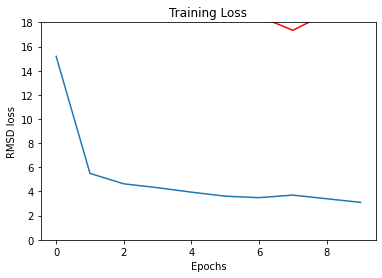

In [16]:
#Training
import time
start = time.perf_counter()
model = CG_Classifier(
    num_features=3 #len(graph.ndata)
)

model.to(device)

epochs = 10

b_size = 64
train_dataloader = dtl.pytorch.GraphDataLoader(training_dataset, batch_size=b_size, shuffle=True)#, use_ddp=True)
val_dataloader = dtl.pytorch.GraphDataLoader(val_dataset)


opt = th.optim.Adam(model.parameters(), lr=1e-3) #SGD(model.parameters(), lr=1e-2, momentum=0.9) #
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=100) #OneCycleLR(opt, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=epochs)  #
model.train()


#training setup
val_losses = []
epoch_losses = []
learning_rates = []
for epoch in range(epochs):
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, (batched_graph, batch_labels) in enumerate(train_dataloader):
        batched_graph = batched_graph.to(device)
        batch_labels = batch_labels.to(device)
        l = []
        for graph in dgl.unbatch(batched_graph):
            pred = model(graph)
            l.append(pred)
        
        logits = th.cat(l)
        loss = F.smooth_l1_loss(logits, batch_labels, reduction='mean') # smooth_l1_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)

    #val setup
    val_loss = 0
    for i, (v_graph, v_label) in enumerate(val_dataloader):
        val_pred = model(v_graph)
        v_loss = F.smooth_l1_loss(val_pred, v_label, reduction='mean')  # smooth_l1_loss
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    
    val_losses.append(val_loss)
    
    

    #if epoch >= 20:
    th.save(model.state_dict(), "dgl_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        
end = time.perf_counter()

print("Training took {:.2f} hours".format((end - start)/60/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))

#plot the training run
plt.plot(epoch_losses)
plt.plot(val_losses, 'r')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("RMSD loss")
plt.ylim(ymax=18, ymin=0)
plt.draw()

In [ ]:
#store training run data

file = "loss_data_2022-02-22.txt"

with open("data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates))

In [ ]:
#get training run data

file = "loss_data_2022-02-22.txt"

file_lines = []
with open("data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]

print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))


In [ ]:
#plot the training run
fig, ax1 = plt.subplots(layout='constrained', figsize=(18, 6))
ax1.secondary_yaxis('left')
ax1.plot(epoch_losses)
ax1.plot(val_losses, 'r')
ax2 = ax1.twinx()
ax2.secondary_yaxis('right')
ax2.plot(learning_rates, 'g')
plt.title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=25)
plt.axvline(x = 430, c = 'black', ls = ':')
#plt.axvline(x = 96, c = 'black', ls = ':')
#plt.axvline(x = 145, c = 'black', ls = ':')
#plt.axvline(x = 190, c = 'black', ls = ':')
#plt.axvline(x = 250, c = 'black', ls = ':')
#plt.axvline(x = 321, c = 'black', ls = ':')
#plt.axvline(x = 404, c = 'black', ls = ':')
plt.draw()

In [24]:
#Test Loop
import math
from dgl_classifier.utility import loss_plot, rmsd_scatter, e_rmsd_scatter
@th.no_grad()
def test_loop(model, loader, e_dict, title):
    model.eval()
    max_label = 0
    max_loss = 0
    max_pred = 0
    min_label = math.inf
    min_loss = math.inf
    min_pred = math.inf
    test_losses = []
    true_rmsds = []
    pred_rmsds = []
    energies = []
    trmsds_f_en = []
    prmsds_f_en = []
    for test_graph, test_label in loader:
        test_graph = test_graph.to(device)
        test_pred = model(test_graph)
        test_loss = F.l1_loss(test_pred, test_label).item() #smooth_l1_loss
        test_losses.append(float(test_loss))
        true_rmsds.append(float(test_label))
        pred_rmsds.append(float(test_pred))

        #if test_graph.name[0] in e_dict.keys():
        #    energies.append(e_dict[test_graph.name[0]])
        #    prmsds_f_en.append(float(test_pred))
        #    trmsds_f_en.append(float(test_graph.y))
        if test_loss > max_loss:
            max_loss = test_loss
            max_label = test_label
            max_pred = test_pred
        if test_loss < min_loss:
            min_loss = test_loss
            min_label = test_label
            min_pred = test_pred
        if test_pred < 0:
            print(test_label, test_pred)
    
    print(title)
    print(min_label, min_pred, min_loss)
    print(max_label, max_pred, max_loss)
    test_mean = np.mean(test_losses)
    test_std = np.std(test_losses)
    test_fq = np.quantile(test_losses, q = 0.25)
    test_median = np.median(test_losses)
    test_tq = np.quantile(test_losses, q = 0.75)
    print("Mean Test loss: \t {:.4f}".format(test_mean))
    print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
    print("Min loss: \t\t {:.4f}".format(min(test_losses)))
    print("First Quantile: \t {:.4f}".format(test_fq))
    print("Median: \t\t {:.4f}".format(test_median))
    print("Third Quantile: \t {:.4f}".format(test_tq))
    print("Max Loss: \t\t {:.4f}".format(max(test_losses)))
    
    loss_plot(test_losses, test_fq, test_median, test_tq, title + ", Sorted Test Losses")
    rmsd_scatter(pred_rmsds, true_rmsds, title)
    e_rmsd_scatter(energies, trmsds_f_en, title + ", True RMSDs vs Energy")
    e_rmsd_scatter(energies, prmsds_f_en, title + ", Predicted RMSDs vs Energy")
    return #energies, trmsds_f_en, prmsds_f_en

Test Set
tensor([20.7780], device='cuda:0') tensor([20.7978], device='cuda:0') 0.019811630249023438
tensor([0.], device='cuda:0') tensor([127.4534], device='cuda:0') 127.45335388183594
Mean Test loss: 	 24.5856
Std. Dev. of Test loss:  32.1208
Min loss: 		 0.0198
First Quantile: 	 7.7882
Median: 		 12.1762
Third Quantile: 	 21.7002
Max Loss: 		 127.4534


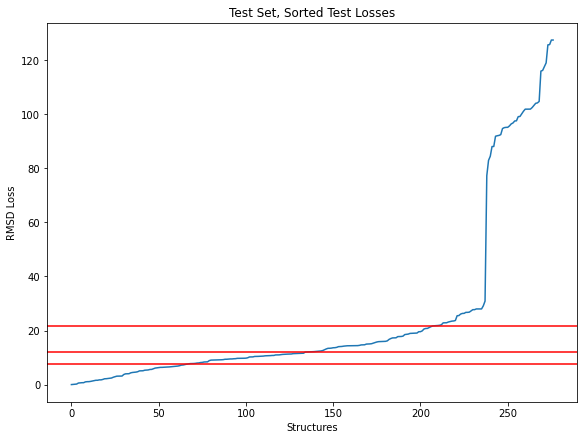

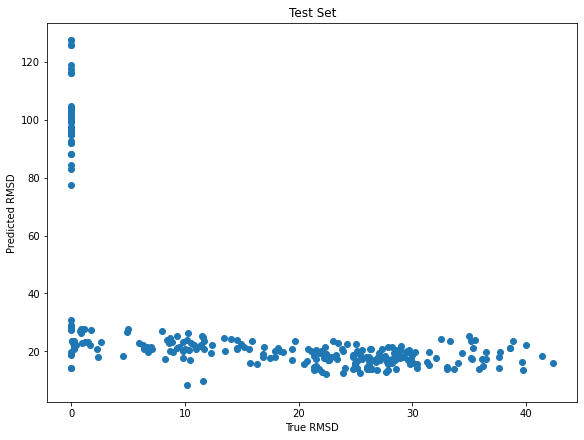

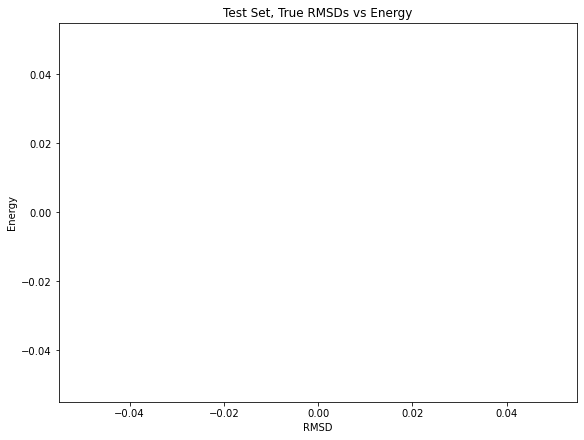

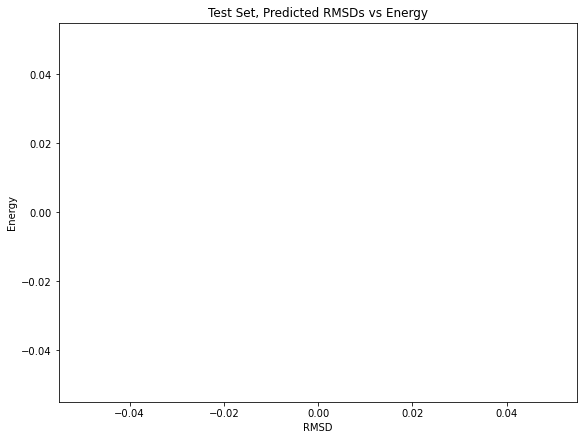

5S and tRNA Test Set
tensor([16.2700], device='cuda:0') tensor([16.2685], device='cuda:0') 0.00154876708984375
tensor([0.], device='cuda:0') tensor([156.3023], device='cuda:0') 156.30227661132812
Mean Test loss: 	 10.1549
Std. Dev. of Test loss:  19.8320
Min loss: 		 0.0015
First Quantile: 	 1.7748
Median: 		 4.0969
Third Quantile: 	 7.9045
Max Loss: 		 156.3023


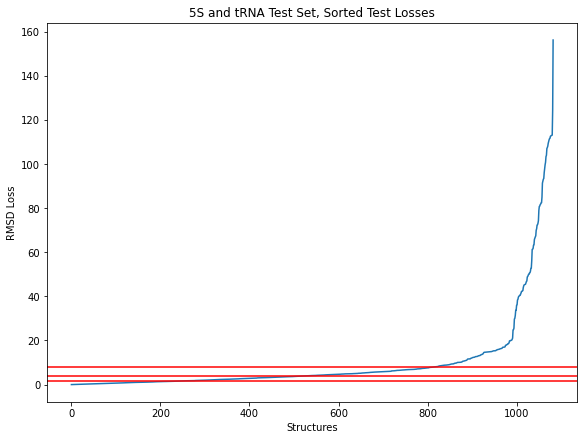

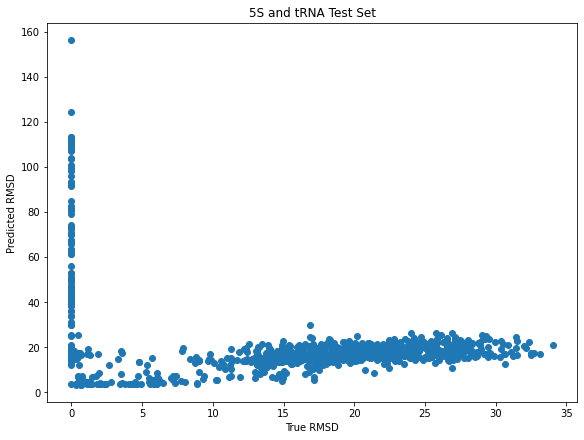

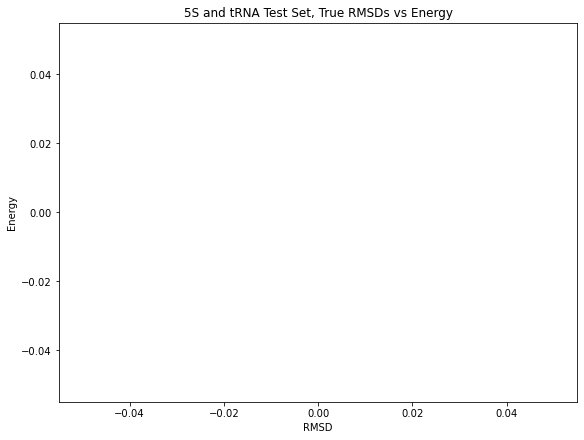

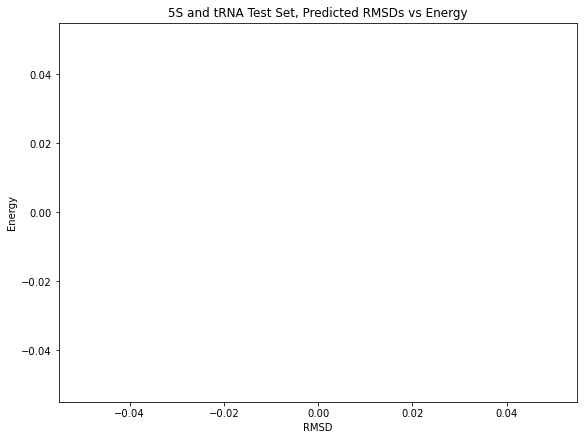

Training Set
tensor([6.1630], device='cuda:0') tensor([6.1607], device='cuda:0') 0.002276897430419922
tensor([0.], device='cuda:0') tensor([18.5346], device='cuda:0') 18.534584045410156
Mean Test loss: 	 4.4734
Std. Dev. of Test loss:  3.6403
Min loss: 		 0.0023
First Quantile: 	 1.5720
Median: 		 3.5364
Third Quantile: 	 6.7386
Max Loss: 		 18.5346


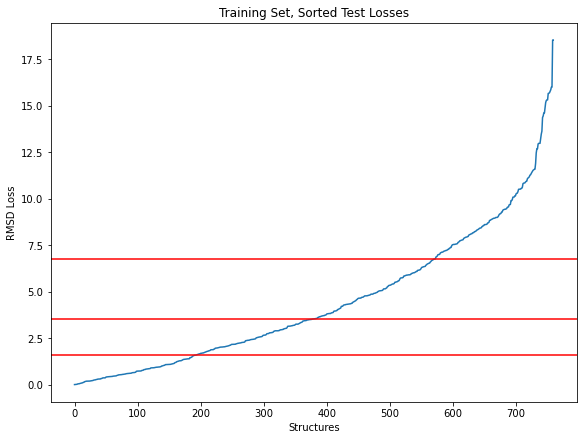

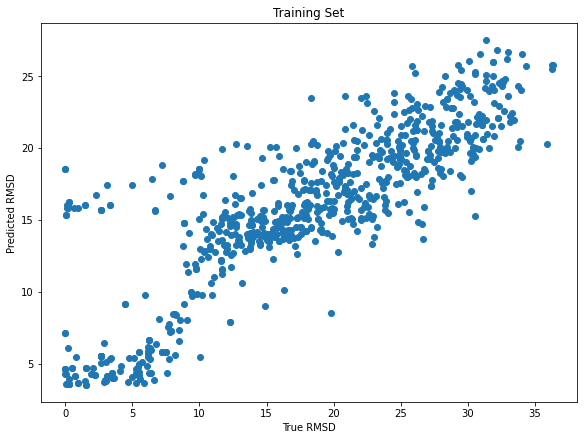

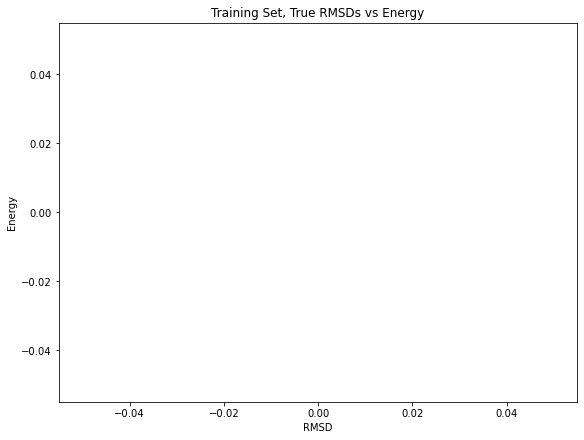

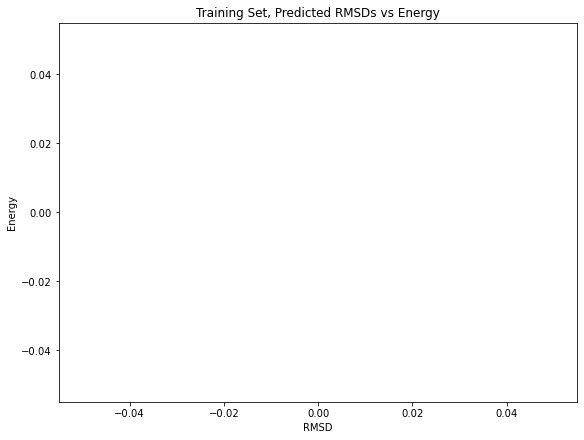

Validation Set
tensor([24.8880], device='cuda:0') tensor([24.8735], device='cuda:0') 0.014513015747070312
tensor([0.], device='cuda:0') tensor([179.3908], device='cuda:0') 179.39077758789062
Mean Test loss: 	 17.8336
Std. Dev. of Test loss:  22.0419
Min loss: 		 0.0145
First Quantile: 	 4.5999
Median: 		 12.3457
Third Quantile: 	 22.4032
Max Loss: 		 179.3908


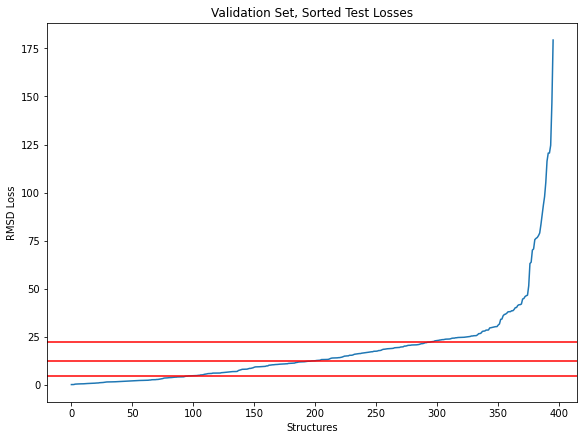

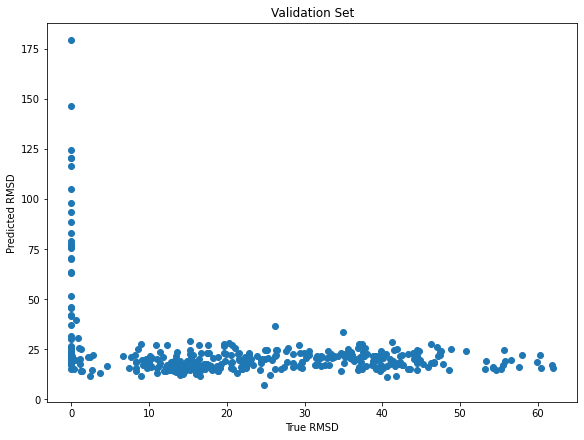

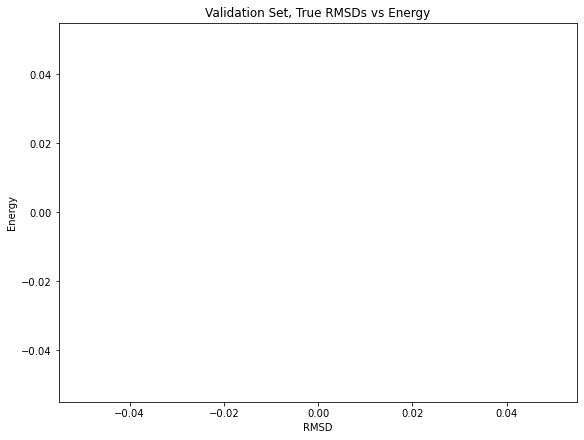

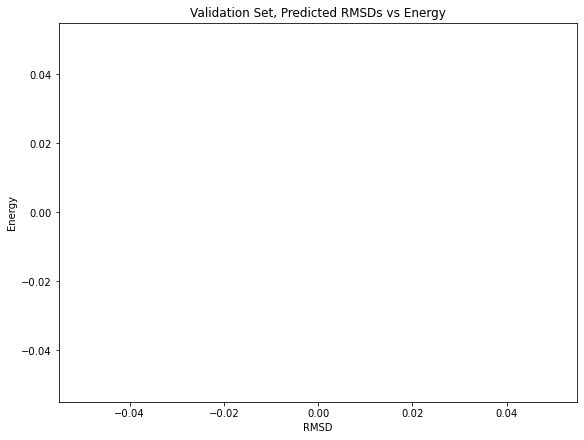

In [25]:
#Test
import math
from dgl_classifier.utility import get_energy_dict

if "model" not in globals():
    model = CG_Classifier(num_features=3)

train_loader = dtl.pytorch.GraphDataLoader(training_dataset)
val_loader = dtl.pytorch.GraphDataLoader(val_dataset)
test_dataloader = dtl.pytorch.GraphDataLoader(test_dataset)
st_test_dataloader = dtl.pytorch.GraphDataLoader(st_test_dataset)
model.to(device)

model.load_state_dict(th.load("dgl_model_data/model_epoch7.pth"))


energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    test_loop(model, loader, e_dict, title)
    #en, trs, prs = test_loop(model, loader, e_dict, title)
    #energy_l += en
    #true_rmsd_l += trs
    #pred_rmsd_l += prs

#e_rmsd_scatter(energy_l, true_rmsd_l, "All structures, True RMSDS vs Energies")
#e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures, Predicted RMSDS vs Energies")
        